# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [11]:
from cs231n.classifiers.neural_net import TwoLayerNet
from cs231n.features import *

for k in range(20,20):
    sys.stdout.write("========= computer k: %s ===========\n" % k)
    sample = np.random.choice(49000, 30000)
    codebook = compute_codebook(X_train[sample], k, True) # compute codebook
    
    feature_fns = [lambda img: hist_from_codebook(img, codebook, k)]
    X_train_feats = extract_features(X_train, feature_fns, verbose=True)
    X_val_feats = extract_features(X_val, feature_fns)

    #print(X_train_feats[0], mean_feat[0])
    X_train_feats = X_train_feats.astype(float)
    X_val_feats = X_val_feats.astype(float)
    
    mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
    X_train_feats -= mean_feat
    X_val_feats -= mean_feat

    std_feat = np.std(X_train_feats, axis=0,keepdims=True)
    X_train_feats /= std_feat
    X_val_feats /= std_feat

    X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
    X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
    

    input_dim = X_train_feats.shape[1]
    num_classes = 10

    learning_rate_decay = 0.95
    num_iters = 100
    learning_rates, regularization_strengths, batch_sizes, hidden_dims = [1.5], [0.0005], [500], [500] #0.625

    best_net = None
    best_acc = 0.0

    count = 0
    for reg in regularization_strengths:
        for lr in learning_rates:
            for hd in hidden_dims:
                for bs in batch_sizes:
                    # Train the network
                    net = TwoLayerNet(input_dim, hd, num_classes)
                    stats = net.train(X_train_feats, y_train, X_val_feats, y_val, lr, learning_rate_decay, reg, num_iters, bs, verbose=True)
                    # Predict on the validation set
                    val_acc = (net.predict(X_val_feats) == y_val).mean()
                    if (val_acc > best_acc):
                        best_net = net
                        best_acc = val_acc
                        print("lr: ", lr , " reg: " ,reg , " bs: ", bs ,"hs: ", hd," acc: ",val_acc)

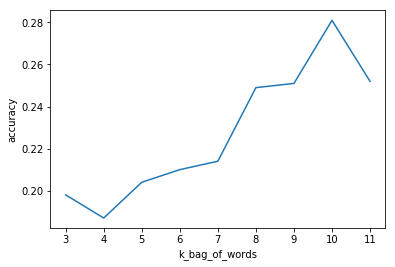

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [i for i in range(3, 12)]
y = [0.198, 0.187, 0.204,0.21 ,0.214,0.249,0.251 ,0.281, 0.252]

plt.xlabel('k_bag_of_words')
plt.ylabel('accuracy')
plt.plot(x, y)
plt.show()